<h1>LBP算法实验报告</h1>
<br>张栋玮 &nbsp 19373703 &nbsp <a href="https://github.com/ZhangDw529/LBP">在GITHUB中查看</a></br>

---

<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#简介" data-toc-modified-id="简介-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>简介</a></span></li><li><span><a href="#算法实现" data-toc-modified-id="算法实现-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>算法实现</a></span></li><li><span><a href="#有无旋转不变对比" data-toc-modified-id="有无旋转不变对比-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>有无旋转不变对比</a></span></li><li><span><a href="#直方图" data-toc-modified-id="直方图-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>直方图</a></span></li><li><span><a href="#人脸识别" data-toc-modified-id="人脸识别-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>人脸识别</a></span></li><li><span><a href="#参考文献" data-toc-modified-id="参考文献-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>参考文献</a></span></li><li><span><a href="#附件" data-toc-modified-id="附件-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>附件</a></span></li></ul></div>

---
## 简介
<br>LBP（Local Binary Pattern，局部二值模式）是一种用来描述局部纹理特征的算子，具有旋转不变性（加入处理）和亮度不变性等特征，可以用于纹理分类、人脸识别等应用场景。</br>
<br>本次实验首先对LBP算法进行了实现，对比了有无旋转不变性的图像特征，之后绘制了LBP特征直方图，最后使用两组图片进行了人脸识别测试，使用了加权卡方检验，公式如下：</br>
<img src="./chi.jpg" alt="weighted chi-square" width="200" height ="100" title="weighted chi-square">
<br>旋转不变性指的是不同旋转角度下，得到的LBP值相同。本实验中计算LBP时，默认从左上角开始，顺时针进行。要实现旋转不变，只需要在从任意一个Neighbor开始计算得到的LBP值中选择最小值即可。这一过程可以直接通过将二进制数右移至最低位为1，这样计算速度更快。在使用旋转不变后，由于灰度值存在下降，得到的图片纹理更加明显，图片整体更黑。示意图如下：</br>
<img src="./rot_inv.jpg" 
     alt="Rotational invariance"
     width="400"
     height="341"
     title="Rotational invariance">
<br>从实验结果来看，当Gallery中存在匹配的人脸图片时，LBP算法可以较好实现人脸识别。但是在表情不同、人脸位置不同的情况下，匹配效果不是很理想。考虑不理想的原因有以下几条：</br>

1. 图片数据是自己在网上随机查找并统一处理成224x224的，数据量少，角度表情不一，并且图片中存在较多较多干扰，面部图像没有占据整张图片，并且诸如“痦子”这样的特征在图像上显现不出来。
    
2. LBP算法本身可以进一步添加更多参数，而在本实验中重点在于理解原理，因此没有过多关注参数对结果的影响。
    
3. 图像分割方法给LBP带来局限。由于LBP划分Block时是横平竖直的，并且分割之后一定程度上消除了各部分的联系，这样对于一些不标准的图片就会匹配不佳。

<p>总体来说，LBP算法计算简单，亮度不变性较强，而对人像的角度、大小、表情等要求较高。除了结合其他图像处理技术外，上述局限性可以通过对人脸数据采集过程提高标准来解决，比如我们在日常生活中使用手机进行一些高安全性人脸识别时，通常被要求面部填充满给出的框架，并且要更换角度（比如点点头、左右转等），以及张开嘴巴等。在进行严格的图像采集后，人脸识别算法也更加精准安全，因此LBP算法应用也较为方便。</p>

---
## 算法实现

In [4]:
import torch
import cv2
import numpy as np
import time

In [5]:
# Preprocess: convert color of images
# for i in range(5):
#     f = cv2.imread(f"./Trump/Trump{i}.jpg")
#     G = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
#     cv2.imwrite(f"Trump{i}.jpg",G)

In [6]:
G = cv2.imread('./Trump/Trump0.jpg',cv2.IMREAD_GRAYSCALE)
cv2.imshow('Trump0.jpg',G)
cv2.waitKey(2000) # 2000ms delay
cv2.destroyAllWindows()

In [7]:
# Convert binary to decimal.
def b2d(num,rot_inv=1):
    assert len(num)==8,f"8 bits needed!"
    decimal = 0 
    zeros = 0
    for i in range(8):
        if(num[7-i]==0):
            zeros+=1
        else:
            break
    for i in range(8):
        assert num[i]==0 or num[i]==1,f"Wrong bit"  #ensure 0 or 1
        decimal += num[i]*2**(7-i)
    # The rotational invariance means that we use the minimum LBP value in the set that we start compute at any one of the eight neighbors.
    # It is achieved by bit shift here, which is really fast.
    if(rot_inv==1 and zeros!=8):
        decimal = decimal>>zeros
    #print(decimal)
    return decimal

In [8]:
# Encode the LBP feature value for each center.
def encode(src,i,j,rot_inv=1):
    binary = []
    center = src[i,j]
    # clockwise, high to low bit, 128 to 1
    b1 = src[i-1,j-1]>=center
    b2 = src[i-1,j]>=center
    b3 = src[i-1,j+1]>=center
    b4 = src[i,j+1]>=center
    b5 = src[i+1,j+1]>=center
    b6 = src[i+1,j]>=center
    b7 = src[i+1,j-1]>=center
    b8 = src[i,j-1]>=center
    binary.extend([b1,b2,b3,b4,b5,b6,b7,b8])
    dec = b2d(binary,rot_inv)
    dec = np.uint8(dec)   # change type to uint8 for imshow
    return dec

In [9]:
# Main LBP algorithm
def LBP_Func(src,rot_inv=1):
    v,h = src.shape[0:2]
    dst = src.copy()
    # Set the edge to 255
    dst[0,:]=255
    dst[:,0]=255
    dst[h-1,:]=255
    dst[:,v-1]=255
    for i in range(1,v-1):
        for j in range(1,h-1):
            dst[i,j] = encode(src,i,j,rot_inv)
    return dst

---
## 有无旋转不变对比  

In [10]:
# With rotational invariance.
n = LBP_Func(G)
# Without rotational invariance.
n2 = LBP_Func(G,0)

In [11]:
import matplotlib.pyplot as plt

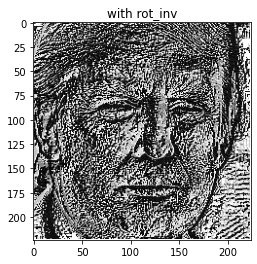

In [12]:
fig = plt.figure()
plt.imshow(n, cmap ='gray')
plt.title("with rot_inv")
plt.show()

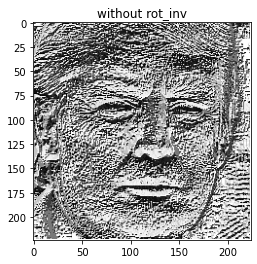

In [13]:
fig = plt.figure()
plt.imshow(n2, cmap ='gray')
plt.title("without rot_inv")
plt.show()

---
## 直方图

<br>(1)以下均以带有旋转不变性的图片进行计算。将图像分割为7*7个Blocks，从左到右，从上到下，Block边长为56像素，分别计算LBP直方图。</br>
<br>(2)由于直接连接起各个Block的直方图后不好显示，所以使用subplot()的形式，但这样做仍然不够清晰，因此在后面又为每个Block单独绘制了直方图，下面给出了(0,0)部分的示例。文末附件中可以找到各个部分的直方图，同时，附件中也给出了整张图片按照Block分割后的LBP统计特征具体数值。</br>
<img src="./hist0.jpg" width="400" height="341">
<br>(3)添加旋转不变性后，LBP可能的数值x一共有129个，即0和1-255间的所有奇数(保证二进制数最低位为1)，降低了特征维度。</br>

In [14]:
x=[0]
x.extend(range(1,256,2))
len(x)

129

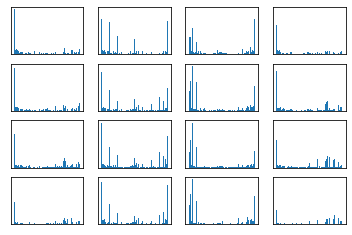

In [15]:
# Histograms in one figure.
# Concatenated figure is not so visible in jupyter environment so I used subplot().
LBP = []
Count = 0
plt.figure()

for divV in range(0,224,56):
    for divH in range(0,224,56):
        
        blockLBP = {}
        block = []
        for i in range(56):
            for j in range(56):
                s = n[divV+i,divH+j]
                block.append(s)
        plt.subplot(4,4,Count+1)
        plt.hist(block,bins=129, density=1)
        plt.xticks([])
        plt.yticks([])
        for k in x:
            #if(block.count(k)>1):
            blockLBP[k] = block.count(k)/56/56
        a = sorted(blockLBP.items(), key=lambda item:item[0])   
        Count+=1
        #print(a)
        #print(len(a))
        LBP.append(a)
#plt.savefig('feature.jpg')

---
## 人脸识别

<br>这一部分采用了直方图加权卡方检验的方法，下面公式中，S为待匹配图像直方图，M为已知图像直方图，其中i=0,1,2,...,N为第i个Block，j=0,1,2,...,128为每个直方图第j个LBP数值,w为每个Block的权重，在此默认为1/16。则两幅图像的相似性为：</br>
<img src="./chi.jpg" width="200" height="100">

In [16]:
# Establish the Gallery LBP features.
Gallery=[]
for i in range(5):
    new = cv2.imread(f"./Trump/Trump{i}.jpg",cv2.IMREAD_GRAYSCALE)
    LBP = []
    for divV in range(0,224,56):
        for divH in range(0,224,56):
            blockLBP = {}
            block = []
            for i in range(56):
                for j in range(56):
                    s = new[divV+i,divH+j]
                    block.append(s)
            for k in x:
                #if(block.count(k)>1):
                blockLBP[k] = block.count(k)/56/56
            a = sorted(blockLBP.items(), key=lambda item:item[0])   
            LBP.append(a)
    Gallery.append(LBP)

In [17]:
# For each picture in Gallery, 16 LBP histograms are recorded.
print("Gallery Size :",len(Gallery))
print("Number of Blocks in one image:",len(Gallery[0]))
print("Number of data in each histogram :",len(Gallery[0][0]))

Gallery Size : 5
Number of Blocks in one image: 16
Number of data in each histogram : 129


In [18]:
# Get the Probe LBP value.
test = cv2.imread("./Trump/Trump0.jpg",cv2.IMREAD_GRAYSCALE)
LBP_test = []
for divV in range(0,224,56):
    for divH in range(0,224,56):
        blockLBP = {}
        block = []
        for i in range(56):
            for j in range(56):
                s = test[divV+i,divH+j]
                block.append(s)
        for k in x:
            #if(block.count(k)>1):
            blockLBP[k] = block.count(k)/56/56
        a = sorted(blockLBP.items(), key=lambda item:item[0])   
        LBP_test.append(a)

In [19]:
LBP_test[0][0][1]  # No.0 Blocks in 16, No.0 Hist-pair in 129, No.1 Data in (x,y)

0.0

In [20]:
Gallery[0][0][0][1] # No.0 Gallery Data, No.0 Blocks in 16, No.0 Hist-pair in 129, No.1 Data in (x,y)

0.0

In [21]:
# Compute the Similarities and get the minimum.
w=[1/32, 1/32, 1/32, 1/32, 
   1/32, 5/32, 5/32, 1/32, 
   1/32, 5/32, 5/32, 1/32, 
   1/32, 1/32, 1/32, 1/32]
chi2 = []  # Chi-square test value
for i in range(5):
    total = 0
    for j in range(16):
        for k in range(129):
            d = LBP_test[j][k][1]-Gallery[i][j][k][1]
            d2 = d*d
            s = LBP_test[j][k][1]+Gallery[i][j][k][1]
            if(s==0):continue
            xw2 = d2/s*w[i]
            total+=xw2
    chi2.append(total)
    print(f"Weighted Chi-2 for No.{i} Gallery-Trump image:",f"{total:.2f}")

Weighted Chi-2 for No.0 Gallery-Trump image: 0.00
Weighted Chi-2 for No.1 Gallery-Trump image: 0.20
Weighted Chi-2 for No.2 Gallery-Trump image: 0.14
Weighted Chi-2 for No.3 Gallery-Trump image: 0.17
Weighted Chi-2 for No.4 Gallery-Trump image: 0.22


<br>测试图实际上选取了Trump0.jpg，因此从以上结果可以看出二者完全加权卡方计算结果为0，表明二者匹配。</br>
<br>下面继续添加了Gallery2-Biden进行对比，但进行对比之后就会发现效果不是很好，主要原因还是数据集不标准，图像质量低，无法突出面部细节，例如“痦子”这样的特征，但整体上已经完成了本次实验的任务，达到学习目的，因此没有继续追求高质量数据。</br>

In [22]:
Gallery2=[]
for i in range(5):
    new = cv2.imread(f"./Biden/Biden{i}.jpg",cv2.IMREAD_GRAYSCALE)
    LBP = []
    for divV in range(0,224,56):
        for divH in range(0,224,56):
            blockLBP = {}
            block = []
            for i in range(56):
                for j in range(56):
                    s = new[divV+i,divH+j]
                    block.append(s)
            for k in x:
                #if(block.count(k)>1):
                blockLBP[k] = block.count(k)/56/56
            a = sorted(blockLBP.items(), key=lambda item:item[0])   
            LBP.append(a)
    Gallery2.append(LBP)

In [23]:
# Compute the Similarities and get the minimum.
w=[1/32, 1/32, 1/32, 1/32, 
   1/32, 5/32, 5/32, 1/32, 
   1/32, 5/32, 5/32, 1/32, 
   1/32, 1/32, 1/32, 1/32]
chi2 = []  # Chi-square test value
for i in range(5):
    total = 0
    for j in range(16):
        for k in range(129):
            d = LBP_test[j][k][1]-Gallery2[i][j][k][1]
            d2 = d*d
            s = LBP_test[j][k][1]+Gallery2[i][j][k][1]
            if(s==0):continue
            xw2 = d2/s*w[i]
            total+=xw2
    chi2.append(total)
    print(f"Weighted Chi-2 for No.{i} Gallery2-Biden image:",f"{total:.2f}")

Weighted Chi-2 for No.0 Gallery2-Biden image: 0.18
Weighted Chi-2 for No.1 Gallery2-Biden image: 0.33
Weighted Chi-2 for No.2 Gallery2-Biden image: 0.26
Weighted Chi-2 for No.3 Gallery2-Biden image: 0.21
Weighted Chi-2 for No.4 Gallery2-Biden image: 0.16


---
## 参考文献
<br>[1] <a href="https://blog.csdn.net/smartempire/article/details/23249517">人脸识别经典算法二：LBP方法</a> </br>
<br>[2] <a href="https://cloud.tencent.com/developer/article/1635791">LBP原理介绍以及算法实现</a> </br>
<br>[3] <a href="https://blog.csdn.net/smartempire/article/details/23203183">卡方检验（Chi square statistic）</a> </br>


---
## 附件

-----------------------------------------------------
LBP Feature at Part(0,0)： [(0, 165), (1, 274), (3, 114), (5, 42), (7, 155), (9, 47), (11, 42), (13, 42), (15, 224), (17, 33), (19, 15), (21, 8), (23, 24), (25, 18), (27, 22), (29, 17), (31, 154), (33, 19), (35, 9), (37, 4), (39, 10), (41, 6), (43, 1), (45, 7), (47, 27), (49, 10), (51, 5), (53, 4), (55, 22), (57, 19), (59, 10), (61, 12), (63, 102), (65, 12), (67, 7), (69, 3), (71, 7), (73, 2), (75, 3), (77, 2), (79, 34), (81, 2), (83, 6), (85, 1), (87, 1), (89, 0), (91, 3), (93, 5), (95, 27), (97, 17), (99, 7), (101, 2), (103, 12), (105, 8), (107, 4), (109, 3), (111, 36), (113, 13), (115, 4), (117, 2), (119, 9), (121, 8), (123, 12), (125, 9), (127, 131), (129, 13), (131, 6), (133, 4), (135, 1), (137, 3), (139, 0), (141, 1), (143, 7), (145, 9), (147, 2), (149, 0), (151, 8), (153, 0), (155, 3), (157, 3), (159, 20), (161, 5), (163, 3), (165, 2), (167, 3), (169, 3), (171, 0), (173, 2), (175, 0), (177, 3), (179, 0), (181, 3), (183, 4), (1

-----------------------------------------------------
LBP Feature at Part(1,2)： [(0, 113), (1, 209), (3, 156), (5, 29), (7, 231), (9, 24), (11, 25), (13, 16), (15, 349), (17, 21), (19, 18), (21, 3), (23, 14), (25, 14), (27, 13), (29, 14), (31, 222), (33, 18), (35, 4), (37, 1), (39, 8), (41, 1), (43, 1), (45, 1), (47, 23), (49, 8), (51, 4), (53, 2), (55, 11), (57, 11), (59, 4), (61, 21), (63, 112), (65, 10), (67, 15), (69, 0), (71, 5), (73, 0), (75, 2), (77, 1), (79, 11), (81, 4), (83, 1), (85, 0), (87, 3), (89, 2), (91, 1), (93, 2), (95, 6), (97, 15), (99, 7), (101, 2), (103, 8), (105, 3), (107, 1), (109, 0), (111, 14), (113, 10), (115, 7), (117, 2), (119, 12), (121, 13), (123, 5), (125, 9), (127, 68), (129, 15), (131, 30), (133, 3), (135, 102), (137, 3), (139, 0), (141, 1), (143, 36), (145, 1), (147, 5), (149, 0), (151, 6), (153, 4), (155, 4), (157, 3), (159, 17), (161, 5), (163, 7), (165, 0), (167, 5), (169, 3), (171, 0), (173, 0), (175, 4), (177, 3), (179, 1), (181, 0), (183, 3), (1

-----------------------------------------------------
LBP Feature at Part(3,0)： [(0, 71), (1, 145), (3, 105), (5, 25), (7, 207), (9, 11), (11, 27), (13, 18), (15, 433), (17, 5), (19, 18), (21, 3), (23, 18), (25, 10), (27, 11), (29, 15), (31, 205), (33, 10), (35, 9), (37, 3), (39, 14), (41, 3), (43, 5), (45, 0), (47, 12), (49, 6), (51, 6), (53, 1), (55, 8), (57, 6), (59, 6), (61, 20), (63, 107), (65, 7), (67, 14), (69, 1), (71, 7), (73, 3), (75, 2), (77, 0), (79, 9), (81, 0), (83, 0), (85, 0), (87, 2), (89, 2), (91, 1), (93, 0), (95, 10), (97, 7), (99, 7), (101, 2), (103, 5), (105, 0), (107, 1), (109, 1), (111, 8), (113, 2), (115, 1), (117, 1), (119, 5), (121, 3), (123, 10), (125, 12), (127, 76), (129, 13), (131, 23), (133, 8), (135, 168), (137, 1), (139, 4), (141, 8), (143, 75), (145, 1), (147, 5), (149, 0), (151, 10), (153, 2), (155, 2), (157, 5), (159, 29), (161, 0), (163, 3), (165, 0), (167, 9), (169, 0), (171, 0), (173, 1), (175, 10), (177, 0), (179, 2), (181, 0), (183, 9), (185, 2

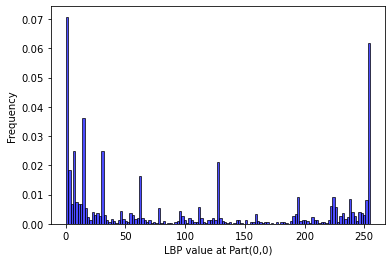

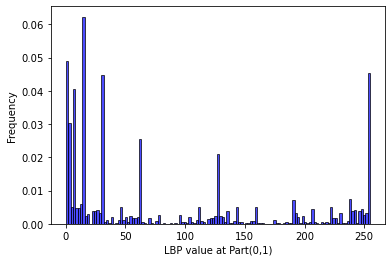

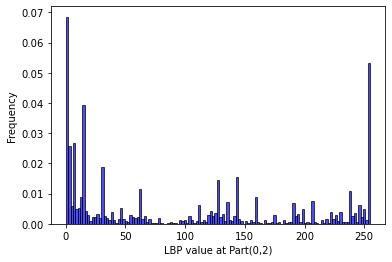

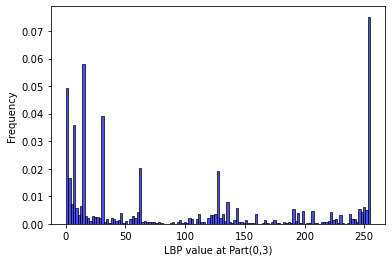

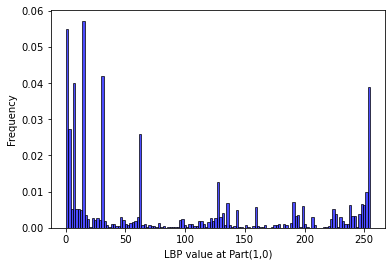

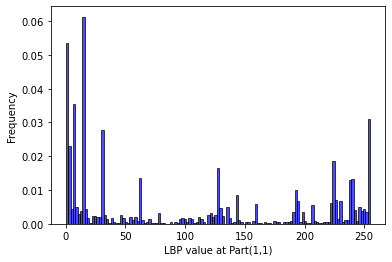

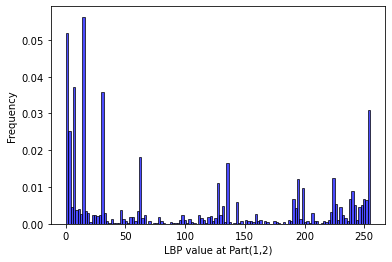

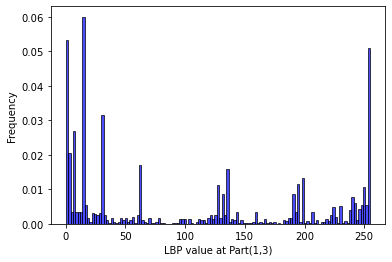

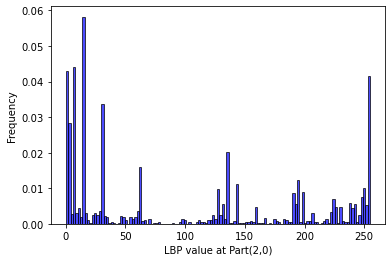

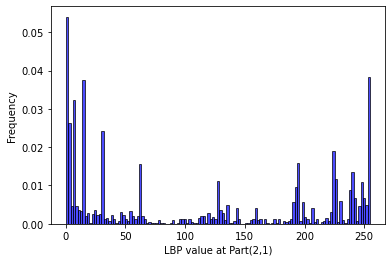

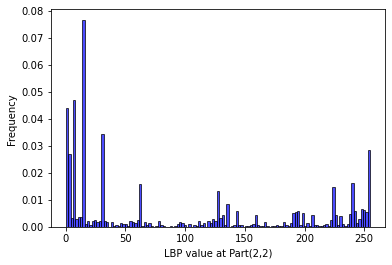

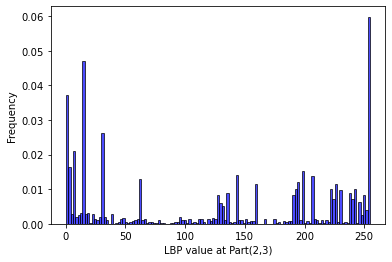

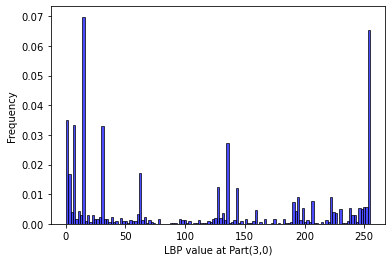

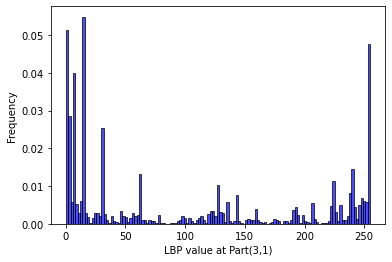

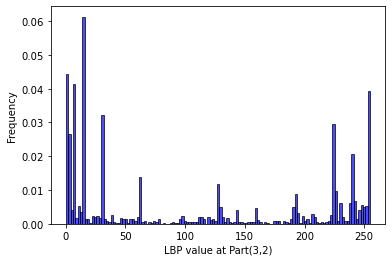

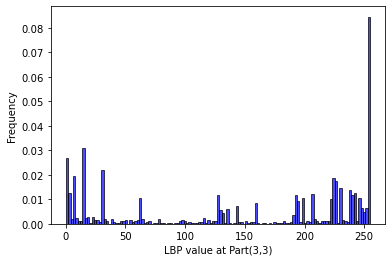

In [24]:
# Separate Histograms
LBP = []
Count = 0
for divV in range(0,224,56):
    for divH in range(0,224,56):

        blockLBP = {}
        block = []
        for i in range(56):
            for j in range(56):
                s = n[divV+i,divH+j]
                block.append(s)
        plt.figure()
        plt.hist(block,bins=129, density=1, facecolor="blue", edgecolor="black", alpha=0.7)
        plt.xlabel(f"LBP value at Part({Count//4},{Count%4})")
        plt.ylabel("Frequency") # Normalized
        #plt.show()
        #plt.savefig(f"hist{Count}.jpg")
        for k in x:
            #if(block.count(k)>1):
            blockLBP[k] = block.count(k)
        a = sorted(blockLBP.items(), key=lambda item:item[0])   
        print("-----------------------------------------------------")
        print(f"LBP Feature at Part({Count//4},{Count%4})：",a)
        print("-----------------------------------------------------")
        #print(len(a))
        Count+=1   
        LBP.append(a)